## Retail Recommender System

### Importing the Libraries 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Importing the Data

In [ ]:
#Reading all the input files 
aisles = pd.read_csv(r'C:\Users\Nikhi\Desktop\97c63414-3-dataset\dataset\Raw Data\aisles.csv')
departments = pd.read_csv(r'C:\Users\Nikhi\Desktop\97c63414-3-dataset\dataset\Raw Data\departments.csv')
prior = pd.read_csv(r'C:\Users\Nikhi\Desktop\97c63414-3-dataset\dataset\Raw Data\order_products__prior.csv')
train = pd.read_csv(r'C:\Users\Nikhi\Desktop\97c63414-3-dataset\dataset\train.csv')
orders = pd.read_csv(r'C:\Users\Nikhi\Desktop\97c63414-3-dataset\dataset\Raw Data\orders.csv')
products = pd.read_csv(r'C:\Users\Nikhi\Desktop\97c63414-3-dataset\dataset\Raw Data\products.csv')

### Feature Engineering

In [12]:
#Merging all the required files to prepare the master dataset
all_orders = pd.concat([prior,train],axis = 0)
all_orders = all_orders.merge(products[['product_id','aisle_id','department_id']], how = 'inner', on = 'product_id')
all_orders = all_orders.merge(aisles, on = 'aisle_id')
all_orders = all_orders.merge(departments, on = 'department_id')
all_orders = all_orders.merge(orders[['order_id','user_id']], on = 'order_id')
all_orders=all_orders.drop("user_id_x",axis=1)
#all_orders=all_orders.rename(columns={user_id_y:user_id})
all_orders=all_orders.rename(columns={'user_id_y':'user_id'})

In [13]:
#Generating the required datasets for the feature engineering 
aisle_hist = all_orders[['user_id','add_to_cart_order','aisle']].groupby(['user_id','aisle']).sum().reset_index()
dept_hist = all_orders[['user_id','add_to_cart_order','department']].groupby(['user_id','department']).sum().reset_index()

In [14]:
#Grouping by user id
user_volume = aisle_hist.groupby('user_id')['add_to_cart_order'].sum()
user_volume = user_volume.reset_index().rename(columns = {'add_to_cart_order':'volume'})
aisle_hist = aisle_hist.merge(user_volume, how = 'inner', on = 'user_id')
dept_hist = dept_hist.merge(user_volume, how = 'inner', on = 'user_id')

In [15]:
#Creating the department share and aisle share for every user
aisle_hist['aisle_share'] = aisle_hist['add_to_cart_order'] / aisle_hist['volume']
dept_hist['dept_share'] = dept_hist['add_to_cart_order'] / dept_hist['volume']

In [16]:
aisle_vol_pivot = aisle_hist[['user_id','aisle','add_to_cart_order']].pivot(index = 'user_id', columns = 'aisle', values = 'add_to_cart_order')
aisle_share_pivot = aisle_hist[['user_id','aisle','aisle_share']].pivot(index = 'user_id', columns = 'aisle', values = 'aisle_share')
dept_vol_pivot = dept_hist[['user_id','department','add_to_cart_order']].pivot(index = 'user_id', columns = 'department', values = 'add_to_cart_order')
dept_share_pivot = dept_hist[['user_id','department','dept_share']].pivot(index = 'user_id', columns = 'department', values = 'dept_share')
#Missing values treatment if any
aisle_vol_pivot = aisle_vol_pivot.fillna(value = 0)
aisle_share_pivot = aisle_share_pivot.fillna(value = 0)
dept_vol_pivot = dept_vol_pivot.fillna(value = 0)
dept_share_pivot = dept_share_pivot.fillna(value = 0)

In [17]:
aisle_share_pivot.shape

(206209, 134)

### Data Preprocessing

#### Principal Component analysis

[0.14275911 0.09706862 0.05840209 0.0485029  0.03763348 0.03351583
 0.0257643  0.02252482 0.02199501 0.02087746 0.02033915 0.01933777
 0.01852009 0.01747105 0.01682903 0.0146591  0.01385221 0.01317521
 0.01231471 0.01113293 0.01067846 0.01052014 0.00998462 0.00984753
 0.00971443 0.00925656 0.00884336 0.00842166 0.00827863 0.00783522]


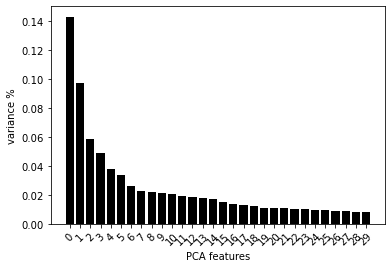

In [19]:
pca = PCA(n_components = 30)
principalComponents = pca.fit_transform(aisle_share_pivot)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.xticks(rotation = 45)

PCA_components = pd.DataFrame(principalComponents)
print(pca.explained_variance_ratio_)

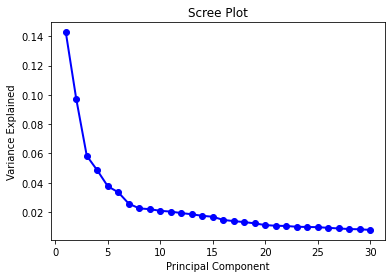

In [20]:


PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

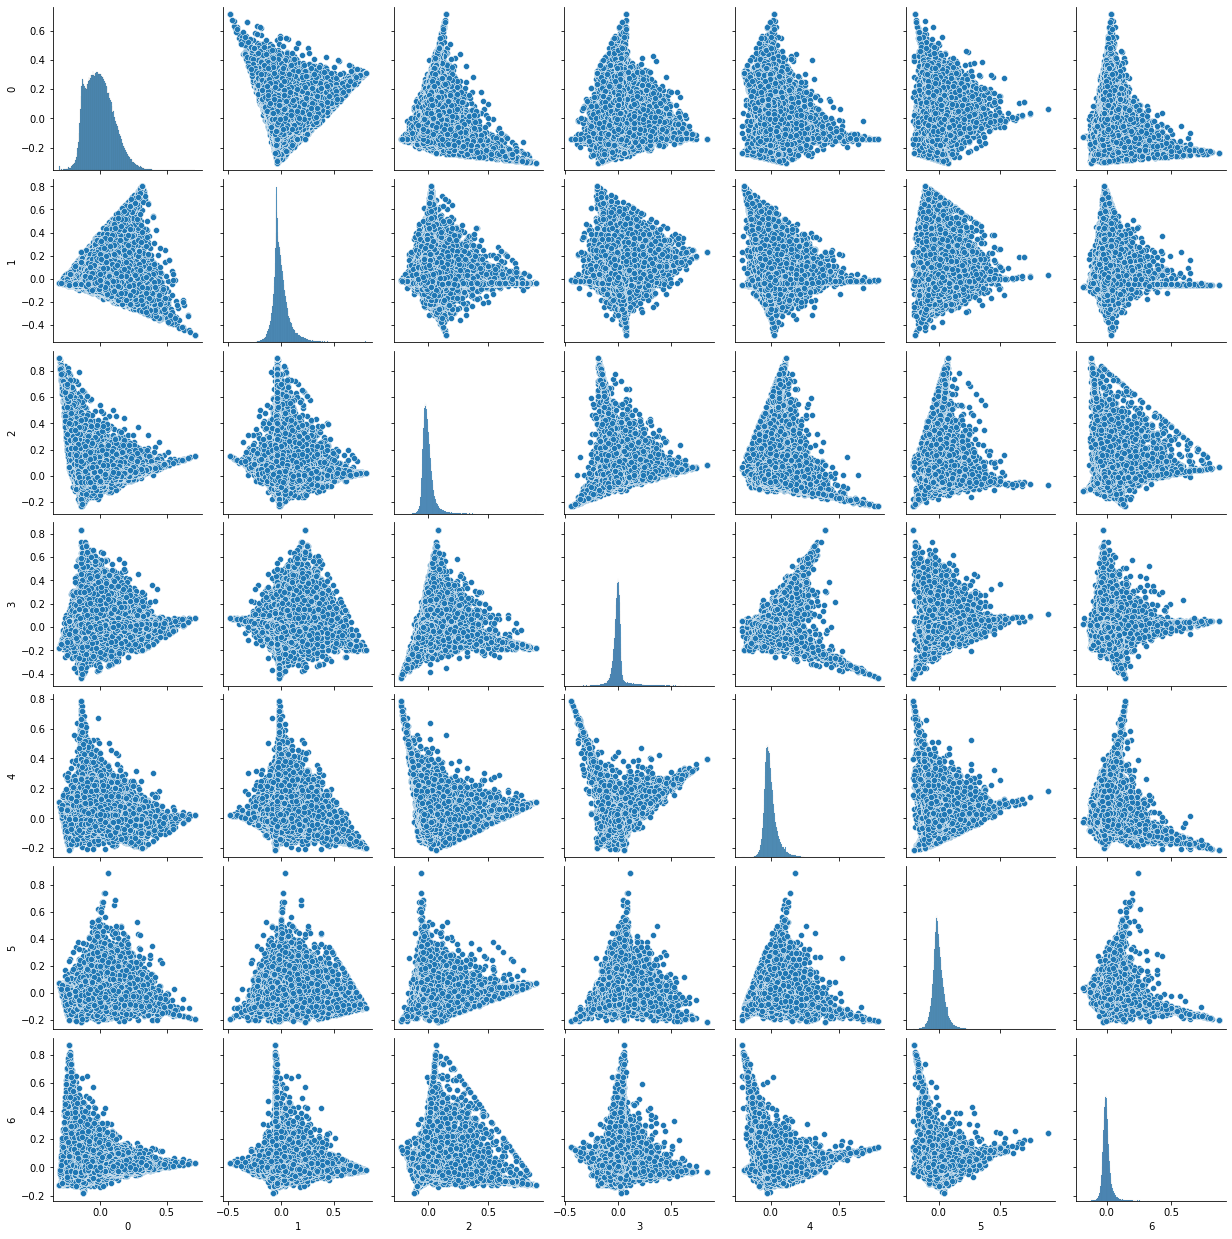

In [21]:
sns.pairplot(PCA_components[[0,1,2,3,4,5,6]])

#### K-means Clustering

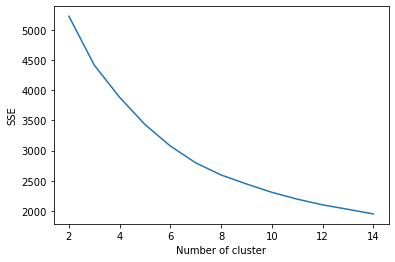

In [23]:
sse = {}
labels = {}
for k in range(2,15):
    kmeans = KMeans(n_clusters = k).fit(PCA_components[[0,1,2,3,4,5]])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [24]:
cluster_df = pd.concat([PCA_components[[0,1,2,3,4,5,6,7]],pd.Series(labels[8]).rename('cluster')], axis = 1)

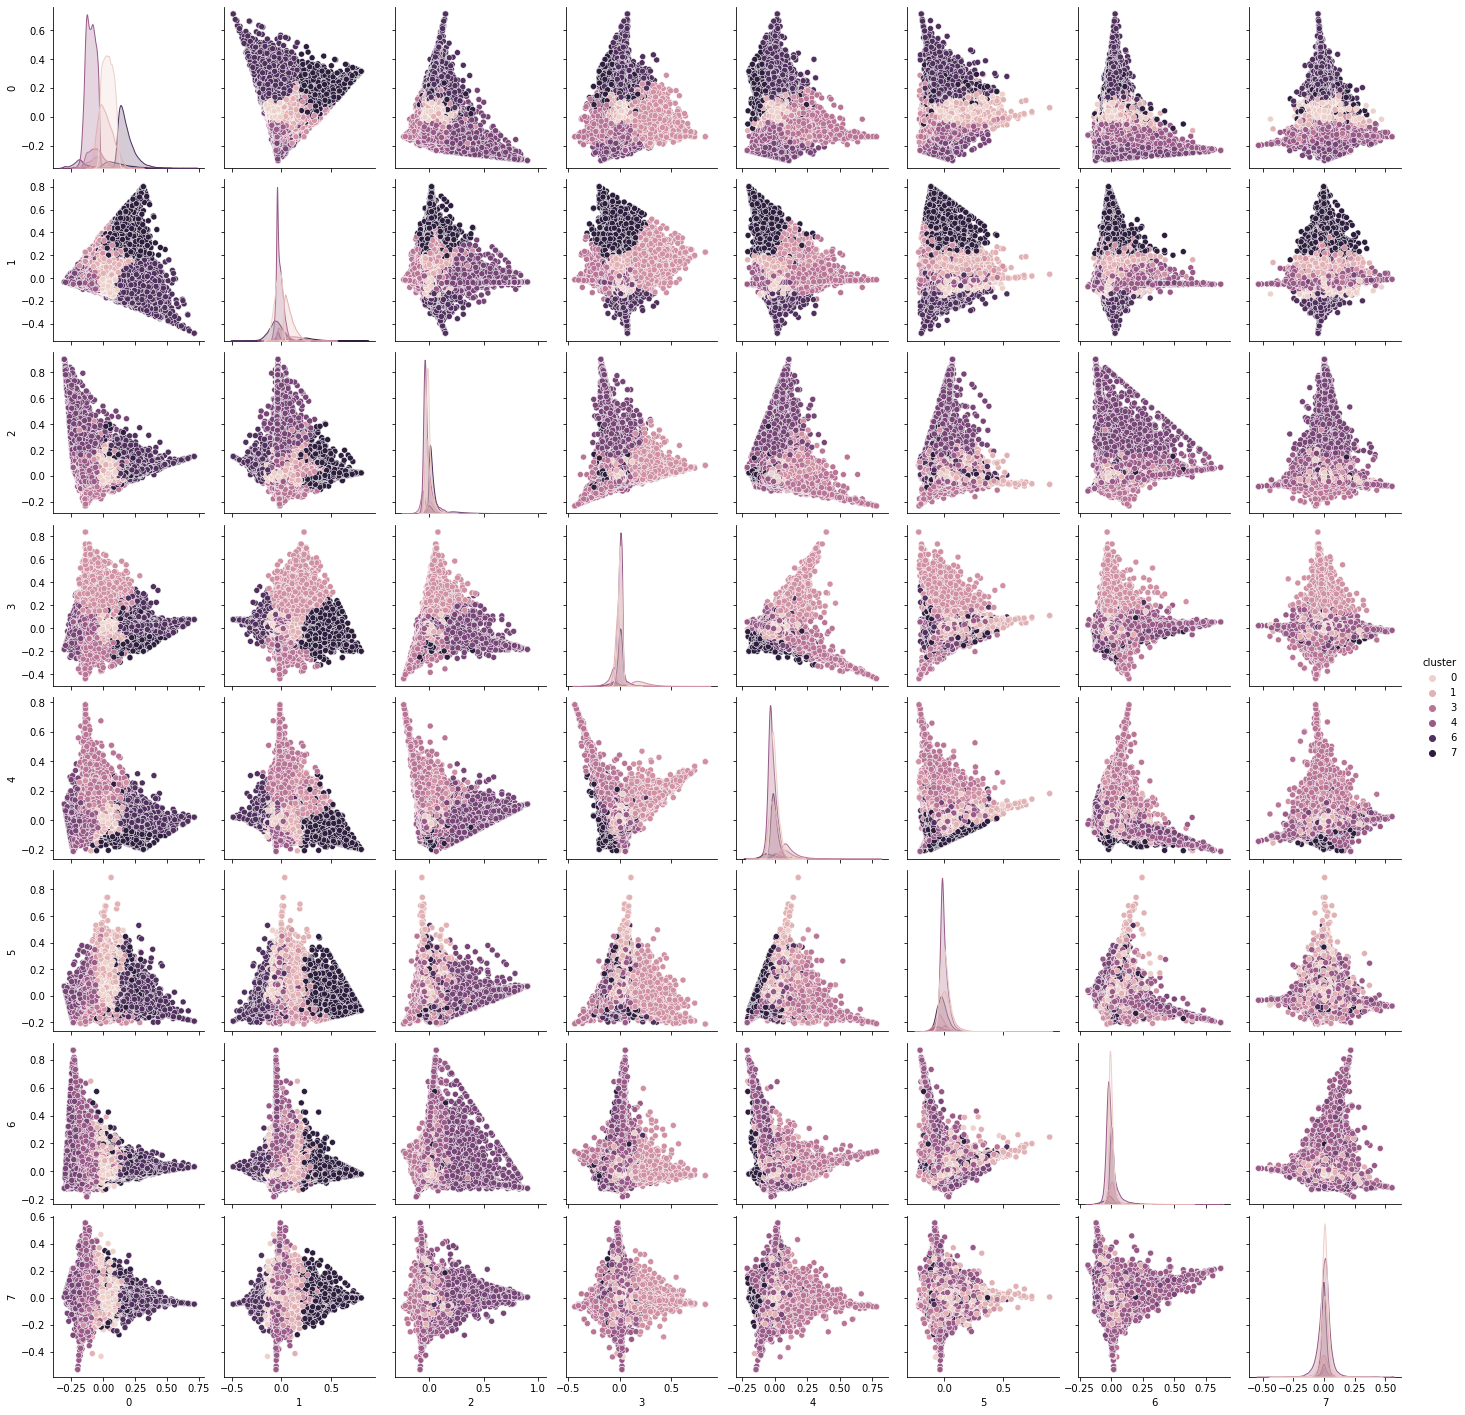

In [25]:
sns.pairplot(cluster_df, hue = 'cluster')

In [26]:
cluster_df = pd.concat([pd.Series(aisle_share_pivot.index),cluster_df],axis = 1)
#cluster_df=cluster_df.drop('user_id',axis=1)
cluster_df.head()

,user_id,0,1,2,3,4,5,6,7,cluster
0,1,-0.094185,0.058436,-0.035147,-0.010894,-0.047822,-0.048825,0.048777,0.059076,4
1,2,-0.077943,0.079341,-0.076903,-0.107504,0.092789,-0.043463,-0.006380,-0.071143,3
2,3,0.057955,0.085509,0.001823,-0.012522,-0.027268,0.113253,0.007863,-0.007106,1
3,4,-0.054413,0.135373,-0.001626,-0.037395,-0.087407,-0.027343,-0.021957,-0.036556,1
4,5,0.144934,-0.018714,-0.020776,-0.004439,0.063260,0.146096,0.048040,0.014283,0


### Master Dataset

In [27]:
cluster_aisle_br = aisle_hist.merge(cluster_df[['user_id','cluster']], on = 'user_id')
cluster_aisle_br = cluster_aisle_br.rename(columns = {'aisle_share':'user_aisle_share'})
aisle_hist = aisle_hist.merge(cluster_df[['user_id','cluster']], on = 'user_id')
aisle_hist = aisle_hist.rename(columns = {'aisle_share':'user_aisle_share'})
dept_hist = dept_hist.merge(cluster_df[['user_id','cluster']], on = 'user_id')
dept_hist = dept_hist.rename(columns = {'dept_share':'user_dept_share'})
cluster_aisle_br = pd.DataFrame(columns = ['aisle','add_to_cart_order','aisle_share','cluster'])

In [28]:
for i in range(0,6):
    x = aisle_hist[aisle_hist['cluster'] == i]
    x = x.groupby('aisle')['add_to_cart_order'].sum().reset_index()
    x['aisle_share'] = x['add_to_cart_order']
    x['aisle_share'] = x['aisle_share'].apply(lambda f: f / x['add_to_cart_order'].sum())
    x['cluster'] = i
    cluster_aisle_br = pd.concat([x,cluster_aisle_br], axis = 0)


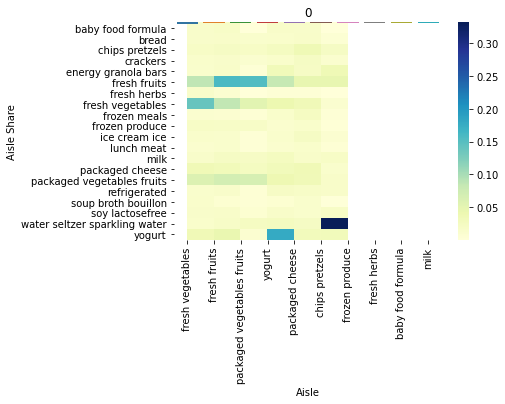

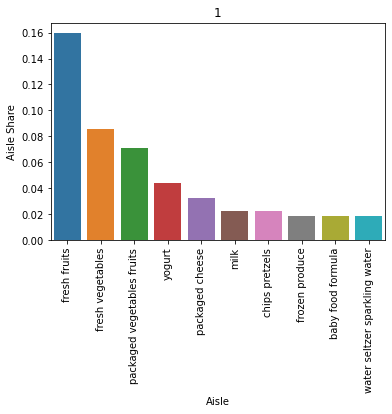

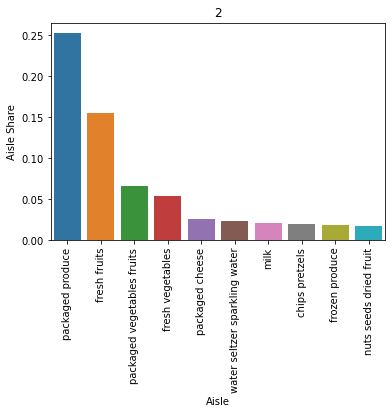

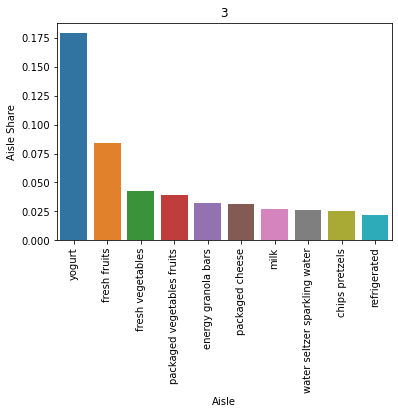

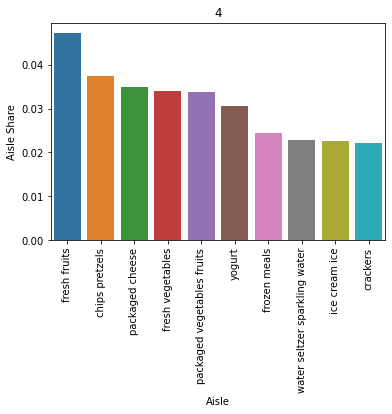

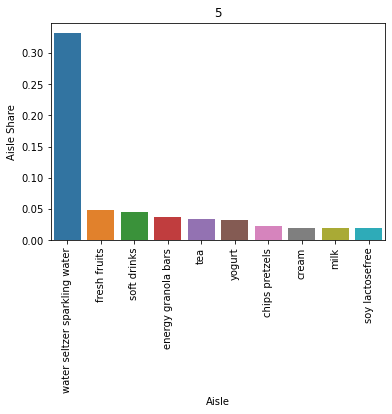

<Figure size 432x288 with 0 Axes>

In [29]:
t20 = list(aisle_hist.groupby('aisle')['add_to_cart_order'].sum().sort_values(ascending = False)[0:20].index)
t30 = list(aisle_hist.groupby('aisle')['add_to_cart_order'].sum().sort_values(ascending = False)[0:30].index)
aisle_heat = cluster_aisle_br[cluster_aisle_br['aisle'].isin(t20)]
aisle_heat = aisle_heat.pivot(index = 'aisle', columns = 'cluster', values = 'aisle_share')
sns.heatmap(aisle_heat,cmap="YlGnBu")
for i in range(0,6):
    x = sns.barplot(data = cluster_aisle_br[cluster_aisle_br['cluster'] == i].sort_values('aisle_share', ascending = False)[0:10], x = 'aisle', y = 'aisle_share')
    x.set_xticklabels(x.get_xticklabels(), rotation=90)
    plt.title(str(i))
    x.set(xlabel = 'Aisle', ylabel = 'Aisle Share')
    plt.figure()


,User Share,Unit Purchase Share
0,26.318444,43.142742
1,16.306272,19.312413
2,3.747169,0.872251
3,5.539525,6.105114
4,31.263427,30.171976
5,1.798176,0.395503
6,12.759385,NaN
7,2.267602,NaN


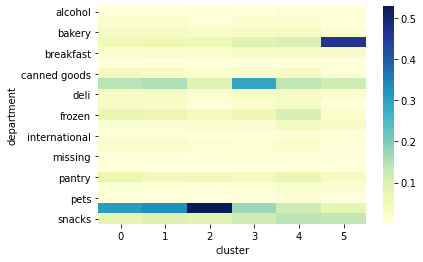

In [30]:
cluster_dept_br = pd.DataFrame(columns = ['department','add_to_cart_order','dept_share','cluster'])
for i in range(0,6):
    x = dept_hist[dept_hist['cluster'] == i]
    x = x.groupby('department')['add_to_cart_order'].sum().reset_index()
    x['dept_share'] = x['add_to_cart_order']
    x['dept_share'] = x['dept_share'].apply(lambda f: f / x['add_to_cart_order'].sum())
    x['cluster'] = i
    cluster_dept_br = pd.concat([x,cluster_dept_br], axis = 0)
cluster_dept_br[cluster_dept_br['cluster'] == 5].dept_share.sum()
dept_heat = cluster_dept_br.pivot(index = 'department', columns = 'cluster', values = 'dept_share')
sns.heatmap(dept_heat,cmap="YlGnBu")
pd.DataFrame(cluster_df['cluster'].value_counts().reset_index())
cluster_df['cluster'].value_counts().sort_index() / cluster_df['cluster'].value_counts().sum() * 100
cluster_aisle_br.groupby('cluster')['add_to_cart_order'].sum() / cluster_aisle_br['add_to_cart_order'].sum() * 100
x = pd.concat([cluster_df['cluster'].value_counts().sort_index() / cluster_df['cluster'].value_counts().sum() * 100,cluster_aisle_br.groupby('cluster')['add_to_cart_order'].sum() / cluster_aisle_br['add_to_cart_order'].sum() * 100], axis = 1)
x.rename(columns = {'cluster':'User Share','add_to_cart_order':'Unit Purchase Share'})

In [31]:
aisle_hist_2=aisle_hist[['cluster','aisle','user_aisle_share']].groupby(['cluster','aisle']).mean()
#aisle_hist_2['Cluster']=aisle_hist_2.index
aisle_hist_2

user_aisle_share
cluster aisle                                          
0       air fresheners candles                 0.011979
        asian foods                            0.018874
        baby accessories                       0.009098
        baby bath body care                    0.007699
        baby food formula                      0.057311
...                                                 ...
7       trash bags liners                      0.032030
        vitamins supplements                   0.030518
        water seltzer sparkling water          0.074541
        white wines                            0.088682
        yogurt                                 0.075664

[1068 rows x 1 columns]

In [ ]:
all_orders = all_orders.merge(cluster_df[['user_id','cluster']], on = 'user_id')
all_orders.drop(['cluster_x'],axis=1)
all_orders.rename(index={'cluster_y':'cluster'})
all_orders_1=all_orders[['user_id','cluster']].drop_duplicates()
all_orders_1.sort_values(by='user_id')
all_orders_2=all_orders[['user_id']].drop_duplicates()
all_orders_2
train1 = train.merge(all_orders[['user_id','cluster']].drop_duplicates(),on='user_id',how='left')
train2 = train1.merge(all_orders[['product_id','aisle']].drop_duplicates(),on='product_id',how='left')
train2.head()
train3 = train2.merge(aisle_hist_2,on=['cluster','aisle'], how='left')
train4 = train3[['ID','cluster','aisle','reordered','user_aisle_share']]
#train4['ID'] = train4['ID'].astype('int')
train4['cluster'] = train4['cluster'].astype('int')
train4.head()
aisle=pd.get_dummies(train4['aisle'])
aisle.shape
l1=aisle.columns.to_list()

train5=train4.merge(aisle,how="inner",left_index=True,right_index=True)
train5.shape



In [32]:
train5.to_pickle("RR_train.pk1")

## Model Development

### Logistic Regression

In [33]:
input_list=['cluster','user_aisle_share']+l1
Y=train5['reordered']
X=train5[input_list]
X.shape

(787911, 136)

In [34]:
#from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X,Y)
Yhat=logreg.predict(X)

C:\Users\Nikhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X, Y)))

Accuracy of logistic regression classifier on test set: 0.64


In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y, Yhat)
print(confusion_matrix)

[[ 72351 237652]
 [ 47102 430806]]


### Random Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X,Y)
Yhat_rf=rf.predict(X)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X, Y)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y, Yhat_rf)
print(confusion_matrix)

Accuracy of random forest classifier on test set: 0.64
[[ 79006 230997]
 [ 51787 426121]]


### Light GBM

In [42]:
import lightgbm as lgb 
gbm=lgb.LGBMClassifier(learning_rate=0.09,max_depth=5,random_state=42)
gbm.fit(X,Y)
Yhat_gbm=gbm.predict(X)
print('Accuracy of light GBM regression classifier on test set: {:.2f}'.format(gbm.score(X, Y)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y, Yhat_gbm)
print(confusion_matrix)

Accuracy of light GBM regression classifier on test set: 0.64
[[ 74132 235871]
 [ 50212 427696]]


### CAT Boost 

In [41]:
from catboost import CatBoostClassifier 
cat=CatBoostClassifier(loss_function='Logloss',eval_metric='Accuracy')
cat.fit(X,Y)
Yhat_cat=cat.predict(X)
print('Accuracy of CAT Boost classifier on test set: {:.2f}'.format(cat.score(X, Y)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y, Yhat_cat)
print(confusion_matrix)

Learning rate set to 0.177717
0:	learn: 0.6210625	total: 199ms	remaining: 3m 18s
1:	learn: 0.6228660	total: 260ms	remaining: 2m 9s
2:	learn: 0.6260986	total: 326ms	remaining: 1m 48s
3:	learn: 0.6248866	total: 396ms	remaining: 1m 38s
4:	learn: 0.6260986	total: 511ms	remaining: 1m 41s
5:	learn: 0.6260986	total: 594ms	remaining: 1m 38s
6:	learn: 0.6271927	total: 676ms	remaining: 1m 35s
7:	learn: 0.6281306	total: 770ms	remaining: 1m 35s
8:	learn: 0.6305052	total: 885ms	remaining: 1m 37s
9:	learn: 0.6290698	total: 972ms	remaining: 1m 36s
10:	learn: 0.6307134	total: 1.09s	remaining: 1m 37s
11:	learn: 0.6316221	total: 1.18s	remaining: 1m 37s
12:	learn: 0.6318747	total: 1.28s	remaining: 1m 37s
13:	learn: 0.6323240	total: 1.38s	remaining: 1m 37s
14:	learn: 0.6323240	total: 1.49s	remaining: 1m 37s
15:	learn: 0.6323455	total: 1.59s	remaining: 1m 37s
16:	learn: 0.6328113	total: 1.69s	remaining: 1m 37s
17:	learn: 0.6323519	total: 1.8s	remaining: 1m 38s
18:	learn: 0.6337480	total: 1.9s	remaining: 1m

157:	learn: 0.6402995	total: 16.7s	remaining: 1m 28s
158:	learn: 0.6402969	total: 16.8s	remaining: 1m 28s
159:	learn: 0.6402969	total: 16.9s	remaining: 1m 28s
160:	learn: 0.6402969	total: 17s	remaining: 1m 28s
161:	learn: 0.6403020	total: 17s	remaining: 1m 28s
162:	learn: 0.6403452	total: 17.1s	remaining: 1m 28s
163:	learn: 0.6403477	total: 17.2s	remaining: 1m 27s
164:	learn: 0.6403731	total: 17.3s	remaining: 1m 27s
165:	learn: 0.6403832	total: 17.4s	remaining: 1m 27s
166:	learn: 0.6403985	total: 17.5s	remaining: 1m 27s
167:	learn: 0.6403997	total: 17.6s	remaining: 1m 27s
168:	learn: 0.6403997	total: 17.7s	remaining: 1m 27s
169:	learn: 0.6403997	total: 17.8s	remaining: 1m 26s
170:	learn: 0.6403997	total: 17.9s	remaining: 1m 26s
171:	learn: 0.6403997	total: 18s	remaining: 1m 26s
172:	learn: 0.6404086	total: 18.1s	remaining: 1m 26s
173:	learn: 0.6404086	total: 18.2s	remaining: 1m 26s
174:	learn: 0.6404086	total: 18.3s	remaining: 1m 26s
175:	learn: 0.6404467	total: 18.4s	remaining: 1m 26s

314:	learn: 0.6408478	total: 32.4s	remaining: 1m 10s
315:	learn: 0.6408478	total: 32.5s	remaining: 1m 10s
316:	learn: 0.6408478	total: 32.5s	remaining: 1m 10s
317:	learn: 0.6408478	total: 32.6s	remaining: 1m 10s
318:	learn: 0.6408478	total: 32.7s	remaining: 1m 9s
319:	learn: 0.6408478	total: 32.8s	remaining: 1m 9s
320:	learn: 0.6408478	total: 32.9s	remaining: 1m 9s
321:	learn: 0.6408478	total: 33s	remaining: 1m 9s
322:	learn: 0.6408478	total: 33.1s	remaining: 1m 9s
323:	learn: 0.6408478	total: 33.2s	remaining: 1m 9s
324:	learn: 0.6408478	total: 33.3s	remaining: 1m 9s
325:	learn: 0.6408554	total: 33.4s	remaining: 1m 9s
326:	learn: 0.6408554	total: 33.5s	remaining: 1m 8s
327:	learn: 0.6408579	total: 33.6s	remaining: 1m 8s
328:	learn: 0.6408579	total: 33.7s	remaining: 1m 8s
329:	learn: 0.6408605	total: 33.8s	remaining: 1m 8s
330:	learn: 0.6408719	total: 33.9s	remaining: 1m 8s
331:	learn: 0.6408719	total: 34s	remaining: 1m 8s
332:	learn: 0.6408719	total: 34.1s	remaining: 1m 8s
333:	learn: 

473:	learn: 0.6410166	total: 48.3s	remaining: 53.6s
474:	learn: 0.6410166	total: 48.4s	remaining: 53.5s
475:	learn: 0.6410166	total: 48.5s	remaining: 53.4s
476:	learn: 0.6410166	total: 48.7s	remaining: 53.4s
477:	learn: 0.6410166	total: 48.8s	remaining: 53.3s
478:	learn: 0.6410166	total: 48.9s	remaining: 53.2s
479:	learn: 0.6410166	total: 49s	remaining: 53.1s
480:	learn: 0.6410166	total: 49.1s	remaining: 53s
481:	learn: 0.6410166	total: 49.3s	remaining: 52.9s
482:	learn: 0.6410166	total: 49.4s	remaining: 52.9s
483:	learn: 0.6410166	total: 49.5s	remaining: 52.8s
484:	learn: 0.6410166	total: 49.6s	remaining: 52.7s
485:	learn: 0.6410166	total: 49.7s	remaining: 52.6s
486:	learn: 0.6410166	total: 49.8s	remaining: 52.5s
487:	learn: 0.6410166	total: 50s	remaining: 52.4s
488:	learn: 0.6410216	total: 50.1s	remaining: 52.4s
489:	learn: 0.6410216	total: 50.2s	remaining: 52.3s
490:	learn: 0.6410216	total: 50.4s	remaining: 52.2s
491:	learn: 0.6410216	total: 50.5s	remaining: 52.1s
492:	learn: 0.6410

633:	learn: 0.6410381	total: 1m 6s	remaining: 38.5s
634:	learn: 0.6410381	total: 1m 6s	remaining: 38.4s
635:	learn: 0.6410381	total: 1m 6s	remaining: 38.3s
636:	learn: 0.6410381	total: 1m 7s	remaining: 38.2s
637:	learn: 0.6410381	total: 1m 7s	remaining: 38.1s
638:	learn: 0.6410381	total: 1m 7s	remaining: 38s
639:	learn: 0.6410381	total: 1m 7s	remaining: 37.9s
640:	learn: 0.6410381	total: 1m 7s	remaining: 37.8s
641:	learn: 0.6410394	total: 1m 7s	remaining: 37.7s
642:	learn: 0.6410394	total: 1m 7s	remaining: 37.6s
643:	learn: 0.6410394	total: 1m 7s	remaining: 37.5s
644:	learn: 0.6410394	total: 1m 7s	remaining: 37.4s
645:	learn: 0.6410394	total: 1m 8s	remaining: 37.3s
646:	learn: 0.6410394	total: 1m 8s	remaining: 37.2s
647:	learn: 0.6410394	total: 1m 8s	remaining: 37.2s
648:	learn: 0.6410394	total: 1m 8s	remaining: 37.1s
649:	learn: 0.6410394	total: 1m 8s	remaining: 36.9s
650:	learn: 0.6410394	total: 1m 8s	remaining: 36.9s
651:	learn: 0.6410394	total: 1m 8s	remaining: 36.8s
652:	learn: 0.

791:	learn: 0.6410559	total: 1m 23s	remaining: 22s
792:	learn: 0.6410559	total: 1m 23s	remaining: 21.9s
793:	learn: 0.6410559	total: 1m 23s	remaining: 21.8s
794:	learn: 0.6410559	total: 1m 24s	remaining: 21.7s
795:	learn: 0.6410559	total: 1m 24s	remaining: 21.6s
796:	learn: 0.6410559	total: 1m 24s	remaining: 21.5s
797:	learn: 0.6410559	total: 1m 24s	remaining: 21.4s
798:	learn: 0.6410559	total: 1m 24s	remaining: 21.3s
799:	learn: 0.6410559	total: 1m 24s	remaining: 21.2s
800:	learn: 0.6410559	total: 1m 24s	remaining: 21.1s
801:	learn: 0.6410559	total: 1m 25s	remaining: 21s
802:	learn: 0.6410559	total: 1m 25s	remaining: 20.9s
803:	learn: 0.6410559	total: 1m 25s	remaining: 20.8s
804:	learn: 0.6410559	total: 1m 25s	remaining: 20.7s
805:	learn: 0.6410559	total: 1m 25s	remaining: 20.6s
806:	learn: 0.6410559	total: 1m 25s	remaining: 20.5s
807:	learn: 0.6410559	total: 1m 25s	remaining: 20.4s
808:	learn: 0.6410559	total: 1m 25s	remaining: 20.3s
809:	learn: 0.6410559	total: 1m 25s	remaining: 20.

949:	learn: 0.6410597	total: 1m 41s	remaining: 5.35s
950:	learn: 0.6410597	total: 1m 41s	remaining: 5.25s
951:	learn: 0.6410597	total: 1m 41s	remaining: 5.14s
952:	learn: 0.6410597	total: 1m 42s	remaining: 5.03s
953:	learn: 0.6410597	total: 1m 42s	remaining: 4.92s
954:	learn: 0.6410597	total: 1m 42s	remaining: 4.82s
955:	learn: 0.6410597	total: 1m 42s	remaining: 4.71s
956:	learn: 0.6410597	total: 1m 42s	remaining: 4.6s
957:	learn: 0.6410597	total: 1m 42s	remaining: 4.49s
958:	learn: 0.6410597	total: 1m 42s	remaining: 4.39s
959:	learn: 0.6410610	total: 1m 42s	remaining: 4.28s
960:	learn: 0.6410610	total: 1m 42s	remaining: 4.17s
961:	learn: 0.6410610	total: 1m 42s	remaining: 4.07s
962:	learn: 0.6410610	total: 1m 43s	remaining: 3.96s
963:	learn: 0.6410610	total: 1m 43s	remaining: 3.85s
964:	learn: 0.6410610	total: 1m 43s	remaining: 3.75s
965:	learn: 0.6410610	total: 1m 43s	remaining: 3.64s
966:	learn: 0.6410610	total: 1m 43s	remaining: 3.53s
967:	learn: 0.6410610	total: 1m 43s	remaining: 

### Xgboost Classifier

In [43]:
from xgboost import XGBClassifier
xgb=XGBClassifier()
xgb.fit(X,Y)
Yhat_xgb=xgb.predict(X)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(xgb.score(X, Y)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y, Yhat_xgb)
print(confusion_matrix)

C:\Users\Nikhi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of logistic regression classifier on test set: 0.64
[[ 78911 231092]
 [ 52227 425681]]


## Association Rule Mining

In [35]:
p1=train.copy()

In [36]:
p1
p1.shape

(787911, 6)

In [4]:
products = pd.read_csv(r'C:\Users\Nikhi\Desktop\97c63414-3-dataset\dataset\Raw Data\products.csv')
orders=pd.merge(p1,products,on="product_id",how="inner")
orders.shape
orders.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'ID', 'product_name', 'aisle_id', 'department_id'],
      dtype='object')

In [5]:
p2=orders.pivot(index="order_id",columns="product_name")['add_to_cart_order'].fillna(0)

In [6]:
newdf=p2.notnull().astype('int')

In [ ]:
from mlxtend.frequent_patterns import apriori,association_rules
#finding frequent item set with minimum support=4%
frequent_itemset=apriori(df=newdf,min_support=0.04, use_colnames=True)
frequent_itemset.sort_values(by="support",ascending=False)

In [ ]:
Rules=association_rules(frequent_items,min_threshold=0.5)
Rules

# Thank you